In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader as pdr
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.formula.api as smf
import random

/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [415]:
def plot_price_series(df, ts1, ts2,start,end):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(start, end)
    ax.grid(True)
    fig.autofmt_xdate()

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()
    

def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()

def plot_residuals(df,start,end):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label="Residuals")
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(start, end)
    ax.grid(True)
    fig.autofmt_xdate()

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()

    plt.plot(df["res"])
    plt.show()
    
def get_conint_params(df_in,e,d,mode=0): 
    #duration = d
    #e = datetime.datetime(2011, 12, 1) 
    s = e - datetime.timedelta(d)
    
    df_in = df_in.loc[(df_in.index>= s) & (df_in.index <= e)].copy()
    
    #####
    df_in = df_in.dropna(axis=0, how='any')

    # Plot the two time series
    #plot_price_series(df, "ts_1", "ts_2",s,e)

        # Display a scatter plot of the two time series
    #plot_scatter_series(df, "ts_1", "ts_2")

        # Calculate optimal hedge ratio "beta"
    res = smf.ols(formula='ts_2~ts_1', data = df_in).fit()
    beta_hr = res.params['ts_1']

        # Calculate the residuals of the linear combination
    df_in["res"] = df_in["ts_2"] - beta_hr*df_in["ts_1"]

        # Plot the residuals
    #plot_residuals(df,s,e)

        # Calculate and output the CADF test on the residuals
    df_in["res"].dropna(inplace=True)


    res_norm = (df_in['res']-df_in['res'].mean())/df_in['res'].std()
    cadf = ts.adfuller(df_in["res"])
    #pprint.pprint(cadf)

    mu = 0
    std = 0
    if cadf[0] < cadf[4]['10%']:#cadf[1] <= 0.1 or
        mu = df_in['res'].mean()
        std = df_in['res'].std()
        #plt.plot(res_norm)
        #plt.show()
        #pprint.pprint(cadf)
        #plot_residuals(df,s,e)
    else: bet_hr = 0
    #print mu,std,beta_hr

    return mu,std,beta_hr
                                               
def out_of_sample_return(df,t_s,t_e,thresh,mu,sigma,beta,wealth,stoplvl):
    
    df_new = df.loc[(df.index>= t_s) & (df.index <= t_e)].copy()
    if sigma == 0:
        df_new['res'] = 0
    else:
        df_new['res']= df_new["ts_2"] - beta*df_new["ts_1"]
        df_new['res'] = (df_new['res'] - mu)/sigma
    
    upper = thresh
    lower = -thresh
    
    df_test_res = df_new['res']
    signal = np.zeros(len(df_test_res))
    
    for i in range(1,len(df_test_res)):
                
        if df_test_res[i-1] > upper and df_test_res[i] <upper:
                signal[i] = -1 
                    
        elif df_test_res[i-1] < lower and df_test_res[i] >lower:
                signal[i] = 2
                
        elif df_test_res[i-1] < upper and df_test_res[i] >upper:
               signal[i] = -2
        
        elif df_test_res[i-1] > lower and df_test_res[i] <lower:
               signal[i] = 1
         
    #plot_price_series(df, "ts_1", "ts_2",t_s,t_e)
    #plt.plot(df_test_res)
    #plt.show()
    df_new['signal'] = signal
    return compute_return(df_new,beta,wealth,stoplvl)

def get_performance(df,start,duration,threshold,mu,sigma,beta,wealth,stoplvl):
    t_s = start+datetime.timedelta(1)
    t_e = t_s + datetime.timedelta(duration)
    score,wealth= out_of_sample_return(df,t_s,t_e,threshold,mu,sigma,beta,wealth,stoplvl)
    return score,wealth


# compute the sortino_ratio for downside risk adjusted return
def sortino_ratio(er, returns, rf, target=0):
    return (er - rf) / np.sqrt(lpm(returns, target, 2))


def lpm(returns, threshold, order):
    # This method returns a lower partial moment of the returns
    # Create an array he same length as returns containing the minimum return threshold
    threshold_array = np.empty(len(returns))
    threshold_array.fill(threshold)
    # Calculate the difference between the threshold and the returns
    diff = threshold_array - returns
    # Set the minimum of each to 0
    diff = diff.clip(min=0)
    # Return the sum of the different to the power of order
    return np.sum(diff ** order) / len(returns)


def annualised_sharpe(returns, N=252):
    if len(returns) > 0:
        #plt.plot(returns)
        #plt.show()
        return np.sqrt(N) * returns[len(returns)-1] / returns.std()
    else :
        return 0
    
#full search of the best result    
def select_best(df,e,train_durations,test_durations,test_thresholds,wealth):
    best_train_duration = 0
    best_test_duration = 0
    best_threshold = 0
    max_score = 0
    best_wealth = 0
    
    
    for train_d in train_durations:
        mu,sigma,beta = get_conint_params(df,e,train_d)
        if (beta is not 0 and sigma is not 0):     
            for t_th in test_thresholds:
                for test_d in test_durations:
                    #print (e,train_d,t_th,test_d)
                    #print mu,sigma
                    score,wealth_temp = get_performance(df,e,test_d,t_th,mu,sigma,beta,wealth)
                    #print score
                    if score > max_score:
                            max_score = score
                            best_train_duration = train_d
                            best_test_duration = test_d
                            best_threshold = t_th
                            best_wealth = wealth_temp
                            #print "max wealth " + str(best_wealth)
                            #print (e,max_score,best_wealth,best_train_duration,best_test_duration,best_threshold)                          
    #return e,max_score,best_wealth,best_train_duration,best_test_duration,best_threshold
    return best_train_duration,best_test_duration,best_threshold


#epsilon greedy search
def epsilon_greedy(Q,train_durations,test_durations,test_thresholds,stoplvls,epsilon):
    if (random.random() < epsilon):
        train_duration = train_durations[random.randint(0,len(train_durations)-1)]
        test_duration = test_durations[random.randint(0,len(test_durations)-1)]
        test_threshold = test_thresholds[random.randint(0,len(test_thresholds)-1)]
        stop_lvl = stop_lvls[random.randint(0,len(stop_lvls)-1)]
        #print "random: "
        #print train_duration,test_threshold,test_duration
    else:
        
        (train_duration,test_duration,test_threshold,stop_lvl) = max(Q, key=Q.get)
        #print "max: "
        #print train_duration,test_threshold,test_duration
    
    return (train_duration,test_duration,test_threshold,stop_lvl)
    

In [416]:
def compute_return(df,beta,wealth=100,margin=100,stoplvl = 0.1):
    
    df = df.dropna(axis=0, how='any')
    l_flag = 0
    s_flag = 0
    #s = pd.DataFrame(columns=['ts_1','ts_2'])
    #l = s
    price_1 = 0
    price_2 = 0
    ret = np.zeros(df.count()[0])
    #wealth_v = np.empty(df.count()[0])
   #wealth_v.fill(wealth)
    #print df.count()[0]
    position_1 = 0
    position_2 = 0
    
    ret_i = 0
    base = 0
    
    if beta ==0:
        return wealth 
    
    else:
        
        #print df
        for index, row in df.iterrows():
        
            if l_flag + s_flag == 0:

                if(int(row['signal']) == -1):
                    #row['positions'] = 'short'
                    #print "open short"
                    #s=s.append(row)
                    s_flag = 1
                    price_1 = row['ts_1']
                    price_2 = row['ts_2']

                    if beta>0:
                        position_1 = wealth/price_1
                        position_2 = margin/(beta*price_2)
                    if beta<0:
                        position_1 = margin/(2*price_1)
                        position_2 = margin/(2*(-beta)*price_2)

                if(int(row['signal']) == 2):
                    #row['positions'] = 'long'
                    #print "open long"
                    #l=l.append(row)
                    l_flag = 1
                    price_1 = row['ts_1']
                    price_2 = row['ts_2']
                    if beta>0:
                        position_1 = margin/price_1
                        position_2 = wealth/(beta*price_2)
                    else:
                        position_1 = wealth/(2*price_1)
                        position_2 = wealth/(2*(-beta)*price_2)

                #ret[ret_i] = base

            else:
                initial_portfolio_val = position_2*price_2 - position_1*beta*price_1
                current_portfolio_val = position_2*row['ts_2'] - position_1*beta*row['ts_1']

                if(s_flag):
                    ret[ret_i] = initial_portfolio_val - current_portfolio_val

                    if ret[ret_i] + wealth < (1-stoplvl) * wealth:
                        print "short stop loss triggered"
                        ret[ret_i] = -stoplvl*wealth
                        wealth = (1-stoplvl)*wealth
                        s_flag = 0

                    if int(row['signal']) == 1:
                        #s=s.append(row)
                        #row['positions'] = 'close_short'
                        #print row
                        #print "short closed!"
                        #print df
                        #base = ret[ret_i]
                        wealth += ret[ret_i]
                        s_flag = 0

                    #if float(ret[ret_i]/initial_portfolio_val) < -0.1:
                    #    ret[ret_i] =  (-0.1) * initial_portfolio_val
                    #    wealth += ret[ret_i]
                    #    s_flag = 0
                    #    print "short stop loss triggered"

                elif(l_flag):
                    ret[ret_i] = current_portfolio_val - initial_portfolio_val

                    if ret[ret_i] + wealth < (1-stoplvl) * wealth:
                        print "long stop loss triggered"
                        ret[ret_i] = -stoplvl*wealth
                        wealth = (1-stoplvl)*wealth
                        l_flag = 0

                    if int(row['signal']) == -2:
                        #l=l.append(row)
                        l_flag = 0
                        #row['positions'] = 'close_long'
                        #print "long closed!"
                        wealth += ret[ret_i]  

                    #if float(ret[ret_i]/initial_portfolio_val) < -0.1:
                    #    ret[ret_i] =  (-0.1) * initial_portfolio_val
                    #    wealth += ret[ret_i]
                    #    l_flag = 0
                    #    print "long stop loss triggered"

            ret_i = ret_i + 1 

        #close any unclosed positions towrads the end of trading window
        if(l_flag>0 or s_flag>0):
                   wealth += ret[ret_i-1]
                   #print "force closed!"

        #print wealth_v

        #plt.plot(ret)
        #plt.show()
    return ret,wealth

In [441]:
class Q_learn:
    
    def update_state_space(self, train_durations,test_durations,test_thresholds,stoplvls):
        self.train_durations = train_durations
        self.test_durations = test_durations
        self.test_thresholds = test_thresholds
        self.stoplvls = stoplvls
        
    def update_params(self,epsilon,alpha,discount):
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount = discount
        
    def __init__(self):
        Q = {}
        Q[(80, 10, 0.8,0.1)] = 0 
        self.Q = Q
        
    def evalutate(self,records):
            i = 1
            vals= []
            for item in np.cumsum(records):
                val = item / i 
                i = i + 1
                vals.append(val)
            #f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            #ax1.plot(vals)
            #ax2.plot(records)   
            plt.plot(vals)
            plt.show()
       
    def RL(self,start_date,end_date,episode,mode = 0):
        records = []
        Q = self.Q
        epsilon = self.epsilon
        alpha = self.alpha
        discount = self.discount
        l = self.discount
        
        train_durations = self.train_durations
        test_durations = self.test_durations
        test_thresholds = self.test_thresholds
        stop_lvls = self.stoplvls
        
        
        A = epsilon_greedy(Q,train_durations,test_durations,test_thresholds,stop_lvls,epsilon)
        for i in range(episode):

            if i > 0.9 * episode:
                epsilon = epsilon * 0.8
            elif i == 0.5 * episode:
                epsilon = epsilon * 0.5
            

            e = start_date
            wealth = 100
            print "episode " + str(i)
            while e < end_date:  
                #print A
                (train_duration,test_duration,test_threshold,stoplvl) = A

                mu,sigma,beta = get_conint_params(df,e,train_duration,mode)
                #print "ok"
                if (beta != 0 and sigma != 0):     
                    score,wealth_out = get_performance(df,e,test_duration,test_threshold,mu,sigma,beta,wealth,stoplvl)
                else:
                    wealth_out = wealth
                #reward update
                R= wealth_out - wealth
                #R= score
                #print R
                if(A not in Q):
                    Q[A] = 0

                A_new = epsilon_greedy(Q,train_durations,test_durations,test_thresholds,stop_lvls,epsilon)
                #A_new = select_best(df,e,train_durations,test_durations,test_thresholds,wealth)

                if(A_new not in Q):
                    Q[A_new] = 0

                Q[A] = Q[A] + alpha * (R + l*Q[A_new]-Q[A])
                
                #state update
                if mu == 0 or mode ==1:
                    test_duration = 10

                e = e+datetime.timedelta(test_duration)
                #print e
                
                
                #action update
                A = A_new

                #wealth update
                wealth = wealth_out
                #print wealth

            records.append(wealth)
            print wealth
            
        self.Q = Q   
        return records,test_duration
    
    

In [409]:
start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2017, 10, 20)
ts_1 = pdr.get_data_yahoo("EURUSD=X", start, end)
ts_2 = pdr.get_data_yahoo("EURGBP=X", start, end)
df = pd.DataFrame(index=ts_1.index)
df["ts_1"] = ts_1["Adj Close"]
df["ts_2"] = ts_2["Adj Close"]

In [ ]:
out = []
out_date = []
train_duration = 3000
test_duration = 500
train_durations = range(50,180,5)
test_durations = range(10,100,5)
test_thresholds = np.arange(0.3,1.5,0.1)
stop_lvls = np.arange(0.01,0.05,0.01)
episode = 100

i = 0
e = datetime.datetime(2011,1,1)
end = datetime.datetime(2017,11,1)
while e < end:  
    
    start_date = e - datetime.timedelta(train_duration)
    end_date = e 
    test_start_date = end_date
    test_end_date = test_start_date + datetime.timedelta(test_duration)
    print "#######epoch " + str(i) + "#######"
    print "######RL started######"
    print "training period is: " + str(start_date) + " to " + str(end_date)
    print "testing period is: " + str(test_start_date) + " to " + str(test_end_date)
#train
    agent = Q_learn()
    agent.update_params(0.3,0.1,0.6)
    agent.update_state_space(train_durations,test_durations,test_thresholds,stop_lvls)
    records,increment = agent.RL(start_date,end_date,episode,0)
    agent.evalutate(records)
    
#test
    agent.update_params(0,0.3,0.5)
    ret,increment = agent.RL(test_start_date,test_end_date,1,0)
    ret[0] = ret[0]-100
    print "Return is " + str(ret[0])
    out_date.append(test_end_date)
    out.append(ret)
    e= e + datetime.timedelta(increment)
    print increment
    i += 1

In [ ]:
agent.Q

In [448]:
a = [(100+x[0])/100 for x in out]

In [449]:
b = np.cumprod(a) * 100

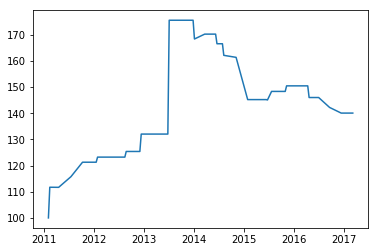

In [450]:
plt.plot(out_date,b)
plt.show()

In [ ]:
# train_duration = 180
# test_duration = 100
# train_durations = range(30,180,10)
# test_durations = range(10,100,10)
# test_thresholds = np.arange(0.3,1.5,0.1)
# stop_lvls = np.arange(0.01,0.10,0.01)
# episode = 1000

# a = [(100+x[0])/100 for x in c]
# b = np.cumprod(a) * 100
# plt.plot(t,b)
# plt.show()

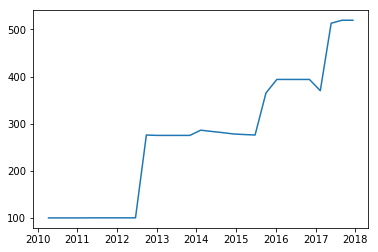